In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
# from transformers import SegformerForSemanticSegmentation
import torch
from torch import nn
import numpy as np
from torchinfo import summary
from helper.models.unet import *
from helper.models.deeplab_mobilenet import *
from helper.models.nvidia_ade20k import *
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
unetmodel = UNet(Config(num_channels=3))

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model = UNet.load_model("Unet-20250428-151636.pt")

In [5]:
from engine.data_setup import *

In [14]:
dataset = get_dataset(mode='test', name='ver5_2012', channels=3)

(3, 256, 256)
(256, 256)
(256, 256, 3)
dem = None


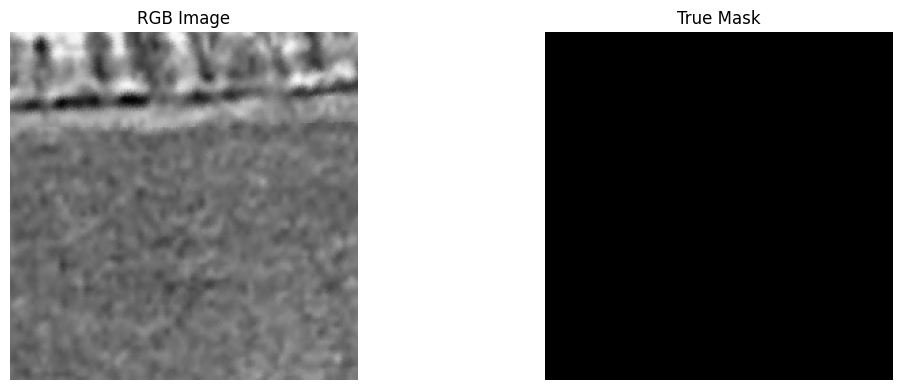

In [15]:
dataset.show(6, augmented=True)

mask: torch.Size([256, 256])
inter: torch.Size([256, 256])


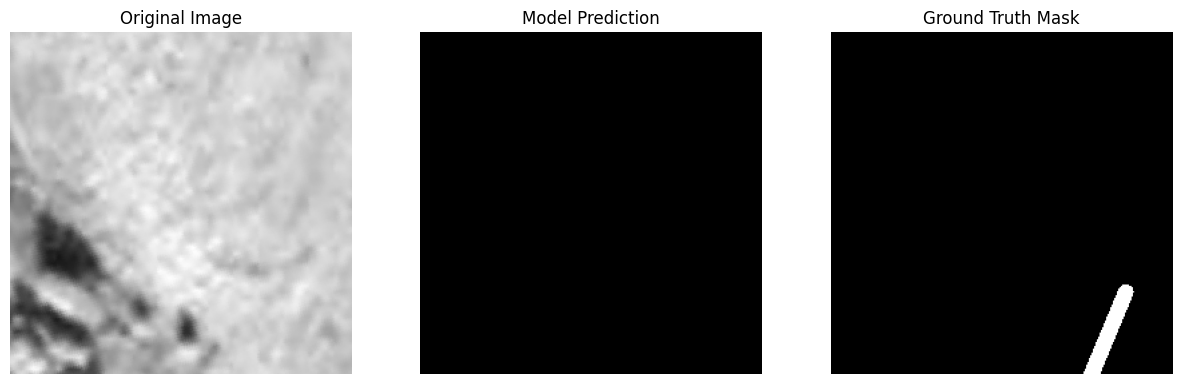

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [26]:
model.predict(dataset[43][0], dataset[43][1], device='cuda', show=True, show_full=False)

In [ ]:
# Important: 34
nonzero_masks = [i for i in range(len(dataset)) if dataset[i][1].sum() != 0]
nonzero_masks

[8,
 11,
 17,
 21,
 26,
 28,
 34,
 43,
 44,
 54,
 58,
 64,
 66,
 68,
 69,
 70,
 74,
 78,
 80,
 81,
 82,
 83,
 86,
 88,
 91,
 92,
 94,
 98,
 104,
 105,
 110,
 117,
 119,
 124,
 130,
 133,
 134,
 138,
 144,
 150,
 153,
 154,
 160,
 164,
 169,
 170]

### Plot

In [ ]:
plot_model = UNet.load_model("Unet-20250428-151636.pt")

In [27]:
plot_dataset = get_dataset(name='dataset_plot_light', mode='test', channels=3)

In [28]:
nonzero_masks = [i for i in range(len(plot_dataset)) if plot_dataset[i][1].sum() != 0]
nonzero_masks

[0,
 1,
 2,
 3,
 5,
 9,
 10,
 12,
 13,
 14,
 16,
 20,
 21,
 24,
 28,
 29,
 31,
 32,
 37,
 41,
 43,
 44,
 46,
 49,
 50,
 54,
 56,
 57,
 59,
 62,
 69,
 70,
 71,
 74,
 77,
 78,
 79,
 82,
 85,
 86,
 87,
 95,
 96,
 104,
 106,
 108,
 109,
 111,
 112,
 113,
 114,
 116,
 117,
 118,
 119,
 122,
 125,
 126,
 127,
 131,
 132,
 137,
 142,
 143,
 145,
 148]

mask: torch.Size([256, 256])
inter: torch.Size([256, 256])


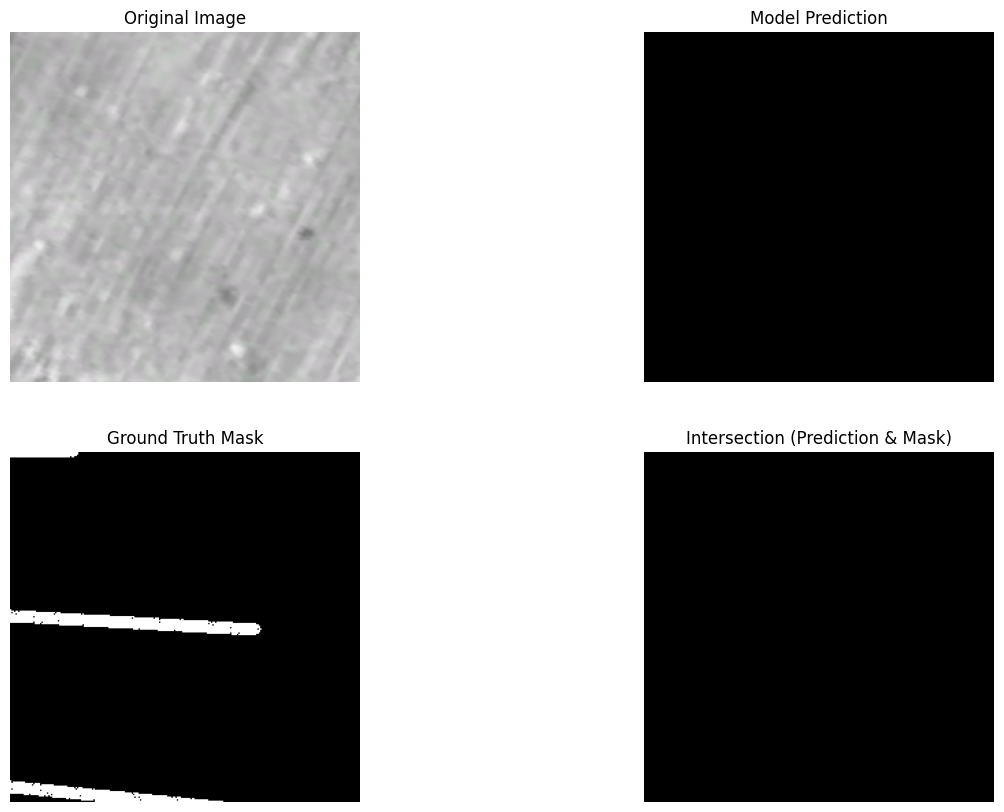

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [43]:
model.predict(plot_dataset[20][0], plot_dataset[20][1], device='cuda', show=True, show_full=True)